### グループで決めたテーマ

「不動産」

物件サイト（スーモなど）を使うことを確認した。

### 個人の仮説について

区などの地域で間取りごとの平均家賃が出ることがあるが、駅までの所要時間で見た間取りごとの平均家賃は見たことがない。

そこで今回は国際展示場駅が最寄り駅になっている物件をスクレイピングし、

新たな範囲の平均家賃の出し方を提案するとともに

「駅に近ければ近いほどどの間取りでも平均家賃が高い」という仮説を立て検証していく。

まず、最寄り駅からの距離、間取り、家賃の情報をスクレイピングし、データベースに格納する。

その後データベースの情報を使い、縦軸が家賃、横軸が間取りの棒グラフと最高家賃と最低家賃の折れ線グラフを合わせたグラフを作成し、そのグラフをもとに分析を行う。

### 国際展示場駅周辺の物件をスクレイピングする

スーモサイトでは沿線、駅ごとに物件を絞り込んむことができる。

今回は物件の最寄り駅が武蔵野大学有明キャンパスの最寄駅であるりんかい線国際展示場駅となっている物件情報を使用する。

物件数：79件

#### テスト用

ここでは主に授業で触れたコードを使い、欲しい要素を取り出せるかを確認する

In [27]:
# Webスクレイピングに最低限必要なライブラリ
import requests
from bs4 import BeautifulSoup
# timeモジュールのsleepメソッドを使ってサーバー負荷を軽減するためにtimeモジュールをインポートする
import time
# SQLiteデータベースを操作するためのライブラリ
import sqlite3

In [28]:
# アクセスしたいWebサイトのURL
base_url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ra=013&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&ek=009014660&rn=0090"
# Webサーバにリクエストを出す
# レスポンスを変数に格納しておく
res = requests.get(base_url)
# 文字化けを防ぐためにエンコーディングを設定
res.encoding = res.apparent_encoding

# アクセスできているかを確認するためにスタータスメッセージを表示させる
print(f"ステータスコード：{res.status_code}")
print(f"ステータスメッセージ：{res.reason}")

ステータスコード：200
ステータスメッセージ：200


In [29]:
# HTMLのソースコードをBeautifulSoupオブジェクトに変換する処理
# html_soup = BeautifulSoup(res.text, 'html.parser')
html_soup = BeautifulSoup(res.content, 'html.parser')
print(f"html_soupの型：{type(html_soup)}")

html_soupの型：<class 'bs4.BeautifulSoup'>


In [30]:
# soup_div = html_soup.div
# soup_div_div = soup_div.div
# div_list = html_soup.find_all('div', class_='cassetteitem_content-tittle', limit=5)
# for div in div_list:
#     print(div.string)

tittle_list = html_soup.select('.cassetteitem_detail-text[style*="font-weight:bold"]', limit=5)
for t in tittle_list:
  print(t.string)

# # idやclass名で検索
# print(html_soup.find_all(id='footer'))
# print(html_soup.find_all(class_='l-header'))

りんかい線/国際展示場駅 歩16分
りんかい線/国際展示場駅 歩13分
りんかい線/国際展示場駅 歩9分
りんかい線/国際展示場駅 歩15分
りんかい線/国際展示場駅 歩15分


In [31]:
import re

tittle_list = html_soup.select('.cassetteitem_detail-text[style*="font-weight:bold"]', limit=5)
for t in tittle_list:
    # 数字のみを抽出
    numbers = re.findall(r'\d+', t.string)
    print(numbers[0])  # ['9'], ['15'] などのリストの最初の要素を取得

16
13
9
15
15


In [32]:
elements = html_soup.select('.cassetteitem_detail-col3',limit=5)
for element in elements:
    tiku = element.find('div').text
    # "築"という文字を除去し、"年"の前の数字だけを取得したい場合
    year = tiku.replace('築', '').replace('年', '')
    print(year)  # "14" が出力されます

11
19
14
11
19


In [33]:
yatin_list = html_soup.select('.cassetteitem_price.cassetteitem_price--deposit', limit=5)
for y in yatin_list:
    print(y.text)

21万円
43.8万円
27.5万円
-
80万円


In [34]:
madori_list = html_soup.select('.cassetteitem_madori', limit=5)
for m in madori_list:
  print(m.string)

1LDK
1LDK
2LDK
2LDK
1LDK


このコードでスクレイピングできることが分かったので、すべてのページのデータの取得を行う

#### 実際のスクレイピング

In [35]:
import requests
from bs4 import BeautifulSoup
import time
import sqlite3
from datetime import datetime

def create_database():
    """データベースとテーブルの作成"""
    conn = sqlite3.connect('real_estate.db')
    cursor = conn.cursor()
    
    # buildingsテーブルの作成
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS buildings (
        building_id TEXT PRIMARY KEY,
        building_name TEXT,
        address TEXT,
        station_distance INTEGER,
        building_age INTEGER,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    )
    ''')
    
    # roomsテーブルの作成
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS rooms (
        room_id TEXT PRIMARY KEY,
        building_id TEXT,
        room_number TEXT,
        rent FLOAT,
        layout TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        FOREIGN KEY (building_id) REFERENCES buildings (building_id)
    )
    ''')
    
    conn.commit()
    conn.close()

def save_to_database(building_room_data):
    """データベースにデータを保存"""
    conn = sqlite3.connect('real_estate.db')
    cursor = conn.cursor()
    
    try:
        for data in building_room_data:
            building_info = data['building_info']
            
            # 建物情報の保存
            cursor.execute('''
            INSERT INTO buildings (building_id, building_name, address, station_distance, building_age)
            VALUES (?, ?, ?, ?, ?)
            ''', (
                building_info['building_id'],
                building_info['building_name'],
                building_info['address'],
                int(building_info['station_distance']) if building_info['station_distance'] else None,
                int(building_info['building_age']) if building_info['building_age'] else None
            ))
            
            # 部屋情報の保存
            for room in data['rooms']:
                rent_value = float(room['rent']) if room['rent'] is not None else None
                cursor.execute('''
                INSERT INTO rooms (room_id, building_id, room_number, rent, layout)
                VALUES (?, ?, ?, ?, ?)
                ''', (
                    room['room_id'],
                    building_info['building_id'],
                    room['room_number'],
                    rent_value,
                    room['layout']
                ))
        
        conn.commit()
        print("データベースへの保存が完了しました")
        
    except Exception as e:
        conn.rollback()
        print(f"データベース保存中にエラーが発生: {e}")
    
    finally:
        conn.close()

def extract_rent_number(rent_text):
    """家賃テキストから数値部分のみを抽出する"""
    try:
        if "万円" in rent_text:
            # "万円"の前の数値部分を抽出
            number_part = rent_text.replace("万円", "").strip()
            return float(number_part)
        else:
            # 数字以外の文字を除去して変換
            number_part = ''.join(filter(lambda x: x.isdigit() or x == '.', rent_text))
            return float(number_part) if number_part else None
    except:
        return None

def scrape_property_data(url):
    all_building_room_data = []
    
    try:
        print("データ取得前に3秒待機します...")
        time.sleep(3)
        
        response = requests.get(
            url,
            headers={
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            }
        )
        
        if response.status_code != 200:
            print(f"ページの取得に失敗しました。ステータスコード: {response.status_code}")
            return all_building_room_data
            
        html_soup = BeautifulSoup(response.content, 'html.parser')
        building_elements = html_soup.select('.cassetteitem')
        
        for building_index, building in enumerate(building_elements, 1):
            try:
                print(f"建物{building_index}の情報を取得中...")
                time.sleep(1)
                
                # 建物情報の取得（変更なし）
                building_name_elem = building.select_one('.cassetteitem_content-title')
                building_name = building_name_elem.text.strip() if building_name_elem else "不明"
                
                address_elem = building.select_one('.cassetteitem_detail-col1')
                address = address_elem.text.strip() if address_elem else "不明"
                
                station_distance = ''
                station_elements = building.select('.cassetteitem_detail-text')
                for station_elem in station_elements:
                    if station_elem.get('style') and 'font-weight:bold' in station_elem.get('style'):
                        distance_text = station_elem.text
                        station_distance = ''.join(filter(str.isdigit, distance_text))
                        break
                
                building_age = ''
                building_age_elem = building.select_one('.cassetteitem_detail-col3 div:first-child')
                if building_age_elem:
                    building_age = building_age_elem.text.replace('築', '').replace('年', '').strip()
                
                building_info = {
                    'building_id': f"B{building_index}",
                    'building_name': building_name,
                    'address': address,
                    'station_distance': station_distance if station_distance else None,
                    'building_age': building_age if building_age else None
                }
                
                # 部屋情報の取得
                rooms_data = []
                room_rows = building.select('.cassetteitem_other tbody tr')
                
                for room_index, room in enumerate(room_rows, 1):
                    try:
                        time.sleep(0.5)
                        
                        # 階数の取得
                        floor_elem = room.select_one('td[class*="cassetteitem_other-col03"]')
                        floor = floor_elem.text.strip() if floor_elem else "不明"
                        
                        # 家賃の取得（修正部分）
                        rent = None
                        rent_elem = room.select_one('.cassetteitem_price.cassetteitem_price--gratuity')
                        if rent_elem:
                            rent_text = rent_elem.text.strip()
                            rent = extract_rent_number(rent_text)
                        
                        # 間取りの取得
                        layout = None
                        layout_elem = room.select_one('.cassetteitem_madori')
                        if layout_elem:
                            layout = layout_elem.text.strip()
                        
                        room_data = {
                            'room_id': f"{building_info['building_id']}_R{room_index}",
                            'room_number': floor,
                            'rent': rent,
                            'layout': layout
                        }
                        
                        rooms_data.append(room_data)
                        print(f"部屋情報の取得成功: 建物ID {building_info['building_id']}, 階数 {floor}, 家賃 {rent}, 間取り {layout}")
                        
                    except Exception as e:
                        print(f"部屋情報の取得中にエラーが発生: {e}")
                        continue
                
                if rooms_data:
                    all_building_room_data.append({
                        'building_info': building_info,
                        'rooms': rooms_data
                    })
                    print(f"建物情報の取得成功: {building_info['building_name']} (部屋数: {len(rooms_data)})")
                
                time.sleep(2)
                
            except Exception as e:
                print(f"建物情報の取得中にエラーが発生: {e}")
                continue
        
        print(f"データの取得が完了しました。取得建物数: {len(all_building_room_data)}")
        
    except Exception as e:
        print(f"処理中にエラーが発生: {e}")
    
    return all_building_room_data

def display_database_data():
    """データベースの内容を表示"""
    conn = sqlite3.connect('real_estate.db')
    cursor = conn.cursor()
    
    print("\n建物情報:")
    cursor.execute('SELECT * FROM buildings')
    buildings = cursor.fetchall()
    print("建物ID | 建物名 | 住所 | 駅距離(分) | 築年数 | 登録日時")
    print("-" * 100)
    for building in buildings:
        print(f"{building[0]} | {building[1]} | {building[2]} | {building[3]} | {building[4]} | {building[5]}")
    
    print("\n部屋情報:")
    cursor.execute('''
    SELECT r.*, b.building_name, b.address 
    FROM rooms r 
    JOIN buildings b ON r.building_id = b.building_id
    ''')
    rooms = cursor.fetchall()
    print("部屋ID | 建物ID | 部屋番号 | 家賃(万円) | 間取り | 登録日時 | 建物名 | 住所")
    print("-" * 120)
    for room in rooms:
        # 家賃の表示
        rent_display = room[3] if room[3] is not None else "不明"
        print(f"{room[0]} | {room[1]} | {room[2]} | {rent_display} | {room[4]} | {room[5]} | {room[6]} | {room[7]}")
    
    conn.close()

def main():
    # データベースの作成
    create_database()
    
    # スクレイピングの実行
    url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ra=013&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&ek=009014660&rn=0090" # スクレイピング対象のSUUMOのURL
    building_room_data = scrape_property_data(url)
    
    # データベースへの保存
    save_to_database(building_room_data)
    
    # 保存したデータの表示
    display_database_data()

def check_property_details():
    """建物と部屋の関連を詳細に確認するための関数"""
    conn = sqlite3.connect('real_estate.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    SELECT 
        b.building_id,
        b.building_name,
        b.address,
        b.station_distance,
        b.building_age,
        r.room_id,
        r.room_number,
        r.rent,
        r.layout
    FROM buildings b
    LEFT JOIN rooms r ON b.building_id = r.building_id
    ORDER BY b.building_id, r.room_id
    ''')
    
    results = cursor.fetchall()
    for row in results:
        print(f"""
        建物ID: {row[0]}
        建物名: {row[1]}
        住所: {row[2]}
        駅距離: {row[3]}分
        築年数: {row[4]}年
        部屋ID: {row[5]}
        部屋番号: {row[6]}
        家賃: {row[7]}円
        間取り: {row[8]}
        """)
    
    conn.close()

if __name__ == "__main__":
    main()

データ取得前に3秒待機します...
建物1の情報を取得中...
部屋情報の取得成功: 建物ID B1, 階数 不明, 家賃 21.0, 間取り 1LDK
部屋情報の取得成功: 建物ID B1, 階数 不明, 家賃 43.8, 間取り 1LDK
部屋情報の取得成功: 建物ID B1, 階数 不明, 家賃 27.5, 間取り 2LDK
部屋情報の取得成功: 建物ID B1, 階数 不明, 家賃 42.0, 間取り 2LDK
部屋情報の取得成功: 建物ID B1, 階数 不明, 家賃 40.0, 間取り 1LDK
部屋情報の取得成功: 建物ID B1, 階数 不明, 家賃 43.0, 間取り 1LDK
建物情報の取得成功: ブリリア有明シティタワー (部屋数: 6)
建物2の情報を取得中...
部屋情報の取得成功: 建物ID B2, 階数 不明, 家賃 50.0, 間取り 2LDK
部屋情報の取得成功: 建物ID B2, 階数 不明, 家賃 28.5, 間取り 1SLDK
部屋情報の取得成功: 建物ID B2, 階数 不明, 家賃 28.0, 間取り 1SLDK
建物情報の取得成功: ガレリアグランデ (部屋数: 3)
建物3の情報を取得中...
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 16.0, 間取り 1LDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 20.0, 間取り 1LDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 20.0, 間取り 1LDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 22.0, 間取り 1LDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 24.0, 間取り 2LDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 24.5, 間取り 2LDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 26.8, 間取り 2LDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 26.8, 間取り 2SLDK
部屋情報の取得成功: 建物ID B3, 階数 不明, 家賃 32.0, 間取り 3LDK
建物情報の取得成功: Ｂｒｉｌｌｉａ 有明 Ｓｋｙ Ｔｏｗｅｒ (部屋数: 9)
建物4の情報を取得中...
部屋情報の取得成功:

##### 失敗した時用

In [36]:
# sqliteでのデータベースの削除
# データベースファイルを削除
# import os
# os.remove('real_estate.db')

### グラフの作成

#### データベースから情報を取得する

全ての距離範囲を複数のグラフで表示します...


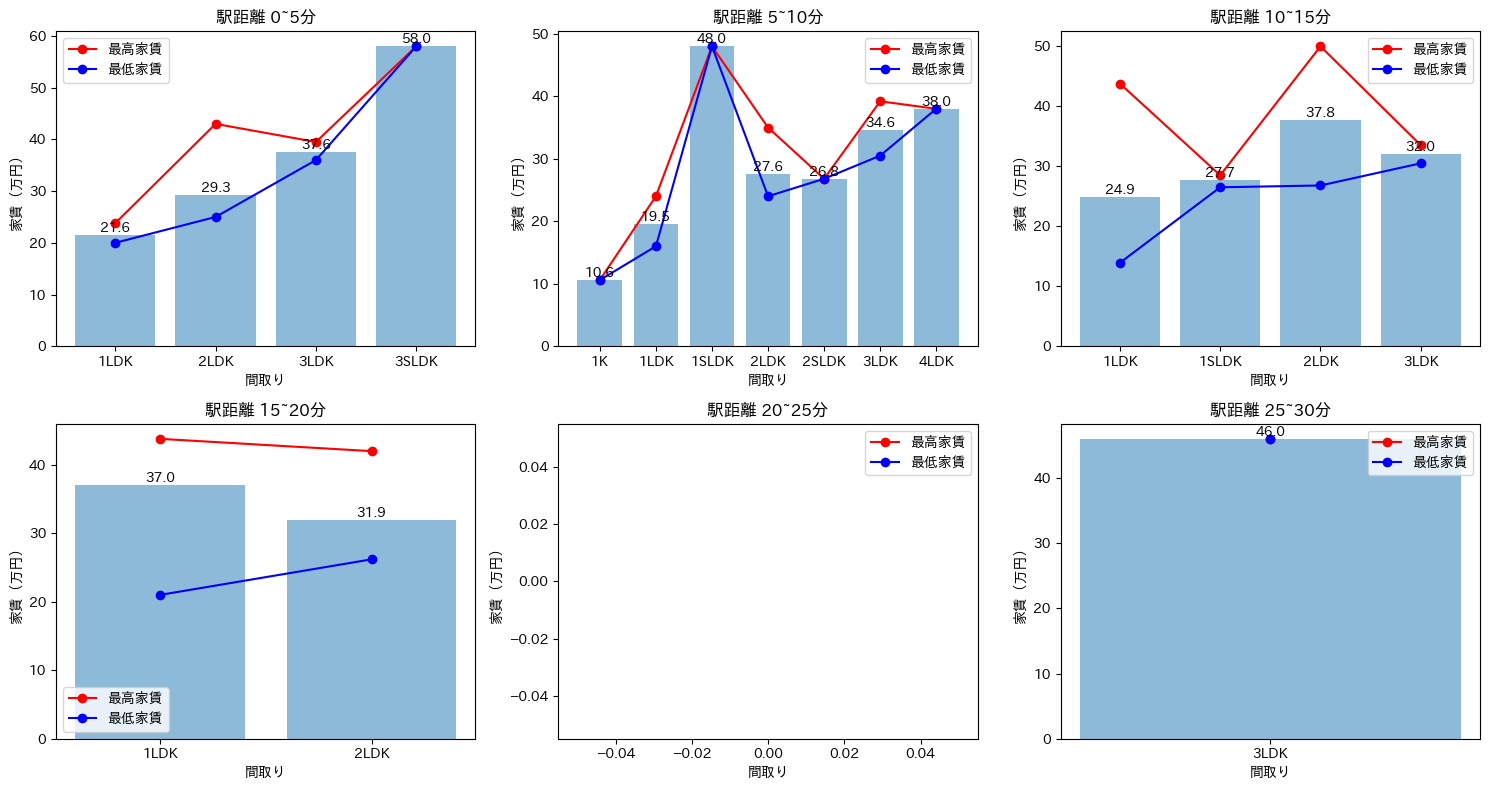

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

def get_rent_stats_by_distance(min_dist, max_dist=None):
    """指定された駅距離範囲での家賃統計を取得"""
    conn = sqlite3.connect('real_estate.db')
    
    if max_dist is None:
        # max_distが指定されていない場合は、min_dist以下のデータを取得
        query = '''
        SELECT r.layout, r.rent
        FROM rooms r
        JOIN buildings b ON r.building_id = b.building_id
        WHERE b.station_distance <= ?
        '''
        params = (min_dist,)
    else:
        # 範囲指定の場合
        query = '''
        SELECT r.layout, r.rent
        FROM rooms r
        JOIN buildings b ON r.building_id = b.building_id
        WHERE b.station_distance > ? AND b.station_distance <= ?
        '''
        params = (min_dist, max_dist)
    
    # DataFrameとして取得
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    # 統計の計算
    stats = df.groupby('layout').agg({
        'rent': ['mean', 'min', 'max']
    }).round(1)
    
    return stats

def plot_single_distance_range(min_dist, max_dist=None, ax=None):
    """単一の距離範囲でのグラフを作成"""
    stats = get_rent_stats_by_distance(min_dist, max_dist)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # 棒グラフ（平均家賃）
    bars = ax.bar(stats.index, stats[('rent', 'mean')], alpha=0.5)
    
    # 折れ線グラフ（最高・最低家賃）
    ax.plot(stats.index, stats[('rent', 'max')], 'r-o', label='最高家賃')
    ax.plot(stats.index, stats[('rent', 'min')], 'b-o', label='最低家賃')
    
    # グラフの設定
    title = f'駅距離 {min_dist}分以下' if max_dist is None else f'駅距離 {min_dist}~{max_dist}分'
    ax.set_title(title)
    ax.set_xlabel('間取り')
    ax.set_ylabel('家賃（万円）')
    ax.legend()
    
    # 棒グラフの上に値を表示
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    if ax is None:
        plt.tight_layout()
        plt.show()

def plot_all_distance_ranges():
    """全ての距離範囲を一つのグラフにまとめて表示"""
    # 距離範囲を増やす
    distance_ranges = [
        (0, 5),
        (5, 10),
        (10, 15),
        (15, 20),
        (20, 25),
        (25, 30)
    ]
    
    # サブプロットのグリッドサイズを計算
    n_plots = len(distance_ranges)
    n_cols = 3  # 1行あたりの列数を指定
    n_rows = (n_plots + n_cols - 1) // n_cols  # 必要な行数を計算
    
    # サブプロットを作成
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.ravel()  # 2次元配列を1次元に変換
    
    # 各距離範囲のグラフを作成
    for i, (min_dist, max_dist) in enumerate(distance_ranges):
        plot_single_distance_range(min_dist, max_dist, axes[i])
    
    # 余分なサブプロットを非表示に
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_combined_distance_ranges():
    """全ての距離範囲を1つのグラフに重ねて表示"""
    # 距離範囲を増やす
    distance_ranges = [
        (0, 5),
        (5, 10),
        (10, 15),
        (15, 20),
        (20, 25),
        (25, 30)
    ]
    
    plt.figure(figsize=(12, 8))
    
    # 色を自動で変える
    colors = plt.cm.rainbow(np.linspace(0, 1, len(distance_ranges)))
    
    for (min_dist, max_dist), color in zip(distance_ranges, colors):
        stats = get_rent_stats_by_distance(min_dist, max_dist)
        label = f'{min_dist}~{max_dist}分'
        plt.plot(stats.index, stats[('rent', 'mean')], 'o-', 
                label=label, color=color)
    
    plt.title('距離範囲別の平均家賃')
    plt.xlabel('間取り')
    plt.ylabel('平均家賃（万円）')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 必要なインポート
import numpy as np  # 追加

def main():
    # 個別のグラフを表示
    # print("個別の距離範囲でのグラフを表示します...")
    # plot_single_distance_range(5)  # 5分以下
    
    # 全ての距離範囲を別々のサブプロットで表示
    print("全ての距離範囲を複数のグラフで表示します...")
    plot_all_distance_ranges()
    
    # 全ての距離範囲を1つのグラフに重ねて表示
    # print("全ての距離範囲を1つのグラフに重ねて表示します...")
    # plot_combined_distance_ranges()

if __name__ == "__main__":
    main()